In [23]:
import sys
sys.path.append("/home/belle2/amubarak/Ds2D0enue_Analysis/08-Python_Functions")

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from Ds2D0e_config import DECAY_CONFIG, BACKGROUND_SAMPLES, get_signal_file, get_generic_file

In [24]:
plt.rcParams.update({
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.titlesize": 16
})

   # Phase 1: Basic Ds and D* composition, no gamma veto

   * Load signal and background using centralized config
   * Apply D0 mass window cuts
   * Look at Ds_mcPDG composition and ancestry
   * Basic Δm_pi and Δm_e distributions
   * D* background categories and 2D structure in (Δm_e, Δm_pi)

In [25]:
# ========================================
# CATEGORY TOGGLES
# ========================================
USE_4_CATEGORIES = False  # background categories: if True, split NaN out of Comb

# Phase 1: DO NOT apply photon-conversion veto
APPLY_GAMMA_VETO = False
GAMMAVETO_THRESHOLD = 0.1  # kept for later phases, not used now

# Control sample toggle (use control-sample ROOT files)
USE_CONTROL_SAMPLE = False
CONTROL_SAMPLE_TAG = "noEID"  # options: "noEID", "wrongCharge", ["noEID", "wrongCharge"], or "all"


# Local aliases to central config
decay_config = DECAY_CONFIG
background_samples = BACKGROUND_SAMPLES

mode_titles = {
    "kmpip": r"$D_s^{+} \rightarrow [D^{0} \rightarrow K^{-} \pi^{+}] e^{+} \nu_{e}$",
    "kmpippi0_eff20_May2020": r"$D_s^{+} \rightarrow [D^{0} \rightarrow K^{-} \pi^{+} \pi^{0}] e^{+} \nu_{e}$",
    "km3pi": r"$D_s^{+} \rightarrow [D^{0} \rightarrow K^{-} 3\pi] e^{+} \nu_{e}$",
}

# ======================================================================
# uproot performance settings
# ======================================================================
UROOT_BRANCH_FILTER = [
    "Ds_mcPDG",
    "D0_*",                  # includes D0_dM and D0 truth
    "Ds_massDifference_0",   # Δm_e
    "Ds_diff_D0pi",          # Δm_pi
    "Ds_isSignal",
    "D0_genMotherPDG",
    "e_mcPDG",
    "e_genMotherPDG",
    # keep daughters in case you uncomment the bottom truth sections
    "K_*",
    "pi_*",
    "pi0_*",
]

UROOT_NUM_WORKERS = 16

# ======================================================================
# Background grouping for composition plots
# 
# This is the place to change if later you:
#   * add "taupair" to BACKGROUND_SAMPLES
#   * merge "charged" and "mixed" into a single BBbar category
# Only groups whose member samples are present in BACKGROUND_SAMPLES
# will be plotted.
# ======================================================================
BKG_GROUP_DEFS = [
    {
        "name": "ccbar",
        "samples": ["ccbar"],
        "label": r"$c\bar{c}$",
    },
    {
        "name": "charged",
        "samples": ["charged"],
        "label": r"$B^{+} B^{-}$",
    },
    {
        "name": "mixed",
        "samples": ["mixed"],
        "label": r"$B^{0} \bar{B^{0}}$",
    },
    {
        "name": "uds",
        "samples": ["uubar", "ddbar", "ssbar"],
        "label": r"$u\bar{u}, d\bar{d}, s\bar{s}$",
    },
    {
        "name": "taupair",
        "samples": ["taupair"],
        "label": r"$\tau^{+}\tau^{-}$",
    },
    # Example for future merge:
    # {
    #     "name": "BBbar",
    #     "samples": ["charged", "mixed"],
    #     "label": r"$B\bar{B}$",
    # },
]

   # Prep work

   ### Import data with D0 mass window cuts

In [26]:
DataFrames = {}  # dictionary to hold dataframes

def _build_tree_paths(file_or_files, tree_name):
    if isinstance(file_or_files, (list, tuple, set)):
        return [f"{f}:{tree_name}" for f in file_or_files]
    return [f"{file_or_files}:{tree_name}"]

print("Loading Signal files (branch filtered)...")
for mode, config in tqdm(list(decay_config.items()), desc="Signal modes"):
    signal_file = get_signal_file(
        mode,
        use_control_sample=USE_CONTROL_SAMPLE,
        control_sample_tag=CONTROL_SAMPLE_TAG,
    )
    signal_tree_paths = _build_tree_paths(signal_file, config['ds_tree'])

    try:
        df = uproot.concatenate(
            signal_tree_paths,
            library="pd",
            filter_name=UROOT_BRANCH_FILTER,
            num_workers=UROOT_NUM_WORKERS,
        )
    except TypeError:
        # fallback if uproot version does not support num_workers
        df = uproot.concatenate(
            signal_tree_paths,
            library="pd",
            filter_name=UROOT_BRANCH_FILTER,
        )

    df = df.query(config["cut"])
    DataFrames[f"Signal_{mode}"] = df

print("\nLoading Background files (branch filtered)...")
for sample in tqdm(background_samples, desc="Background samples"):
    for mode, config in decay_config.items():
        generic_file = get_generic_file(
            sample,
            mode,
            use_control_sample=USE_CONTROL_SAMPLE,
            control_sample_tag=CONTROL_SAMPLE_TAG,
        )
        generic_tree_paths = _build_tree_paths(generic_file, config['ds_tree'])

        try:
            df = uproot.concatenate(
                generic_tree_paths,  # FIXED: was signal_tree_paths
                library="pd",
                filter_name=UROOT_BRANCH_FILTER,
                num_workers=UROOT_NUM_WORKERS,
            )
        except TypeError:
            df = uproot.concatenate(
                generic_tree_paths,  # FIXED: was signal_tree_paths
                library="pd",
                filter_name=UROOT_BRANCH_FILTER,
            )

        df = df.query(config["cut"])
        DataFrames[f"{sample}_{mode}"] = df

print("\nCombining background samples by mode...")
for mode in decay_config.keys():
    dfs_list = [DataFrames[f"{sample}_{mode}"] for sample in background_samples]
    DataFrames[f"All_{mode}"] = pd.concat(dfs_list, ignore_index=True)

print("\nData loading complete!")
print(f"Successfully loaded {len(DataFrames)} dataframes")
print(f"Using {'4' if USE_4_CATEGORIES else '3'} background categories")
print(f"APPLY_GAMMA_VETO = {APPLY_GAMMA_VETO}")
print(f"USE_CONTROL_SAMPLE = {USE_CONTROL_SAMPLE} (type: {CONTROL_SAMPLE_TAG})")
print(f"BACKGROUND_SAMPLES = {background_samples}")
print(f"Branch filter: {UROOT_BRANCH_FILTER}")
print(f"uPROOT workers: {UROOT_NUM_WORKERS}")

Loading Signal files (branch filtered)...


Signal modes:   0%|          | 0/3 [00:00<?, ?it/s]


Loading Background files (branch filtered)...


Background samples:   0%|          | 0/6 [00:00<?, ?it/s]


Combining background samples by mode...

Data loading complete!
Successfully loaded 24 dataframes
Using 3 background categories
APPLY_GAMMA_VETO = False
USE_CONTROL_SAMPLE = False (type: noEID)
BACKGROUND_SAMPLES = ['ccbar', 'charged', 'ddbar', 'mixed', 'ssbar', 'uubar']
Branch filter: ['Ds_mcPDG', 'D0_*', 'Ds_massDifference_0', 'Ds_diff_D0pi', 'Ds_isSignal', 'D0_genMotherPDG', 'e_mcPDG', 'e_genMotherPDG', 'K_*', 'pi_*', 'pi0_*']
uPROOT workers: 16


In [27]:
pd.set_option('display.max_rows', 200000)
pd.set_option('display.max_columns', 200000)

  # PRELIMINARY RESULTS
  ---

  ## Value counts for Ds_mcPDG

   ### Signal samples: Ds_mcPDG and Ds* ancestry checks

In [28]:
# ================================================================
# Signal: Ds_mcPDG, D0_mcPDG, e_mcPDG content per mode
# ================================================================
for mode in decay_config.keys():
    print(f"\n{'='*80}")
    print(f"Signal_{mode} : abs(Ds_mcPDG) fractions")
    print('='*80)

    df_sig = DataFrames[f"Signal_{mode}"]

    # Ds_mcPDG overview
    if "Ds_mcPDG" in df_sig.columns:
        print(
            abs(df_sig["Ds_mcPDG"])
            .value_counts(normalize=True, dropna=False)
            .apply(lambda x: f"{x:.6f}")
        )
    else:
        print("  Column Ds_mcPDG not found")

    # D0_mcPDG overview
    if "D0_mcPDG" in df_sig.columns:
        print(f"\n  abs(D0_mcPDG) fractions (Signal_{mode})")
        print(
            abs(df_sig["D0_mcPDG"])
            .value_counts(normalize=True, dropna=False)
            .apply(lambda x: f"{x:.6f}")
            .head(20)
        )
    else:
        print("  Column D0_mcPDG not found")

    # e_mcPDG overview
    if "e_mcPDG" in df_sig.columns:
        print(f"\n  abs(e_mcPDG) fractions (Signal_{mode})")
        print(
            abs(df_sig["e_mcPDG"])
            .value_counts(normalize=True, dropna=False)
            .apply(lambda x: f"{x:.6f}")
            .head(20)
        )
    else:
        print("  Column e_mcPDG not found")


Signal_kmpip : abs(Ds_mcPDG) fractions
Ds_mcPDG
431.0      0.877374
23.0       0.089897
433.0      0.016757
NaN        0.011373
10431.0    0.001815
20433.0    0.001452
413.0      0.000907
423.0      0.000423
Name: proportion, dtype: object

  abs(D0_mcPDG) fractions (Signal_kmpip)
D0_mcPDG
421.0    0.992619
23.0     0.006836
NaN      0.000544
Name: proportion, dtype: object

  abs(e_mcPDG) fractions (Signal_kmpip)
e_mcPDG
11.0      0.957290
211.0     0.028675
NaN       0.010042
13.0      0.002480
321.0     0.001028
2212.0    0.000484
Name: proportion, dtype: object

Signal_km3pi : abs(Ds_mcPDG) fractions
Ds_mcPDG
431.0      0.803429
23.0       0.149796
NaN        0.023347
433.0      0.017143
413.0      0.002204
20433.0    0.001551
10431.0    0.001061
421.0      0.000735
423.0      0.000653
10413.0    0.000082
Name: proportion, dtype: object

  abs(D0_mcPDG) fractions (Signal_km3pi)
D0_mcPDG
421.0      0.909714
23.0       0.076082
NaN        0.012490
431.0      0.000898
433.0      0.00

   ### Background samples (combined by mode): Ds_mcPDG and Ds* ancestry

In [29]:
# ================================================================
# Background (All): Ds_mcPDG, D0_mcPDG, e_mcPDG content per mode
# ================================================================
for mode in decay_config.keys():
    print(f"\n{'='*80}")
    print(f"All_{mode} (all background samples combined)")
    print('='*80)

    df_bkg = DataFrames[f"All_{mode}"]

    # Ds_mcPDG overview
    if "Ds_mcPDG" in df_bkg.columns:
        print(
            abs(df_bkg["Ds_mcPDG"])
            .value_counts(normalize=True, dropna=False)
            .apply(lambda x: f"{x:.6f}")
        )
    else:
        print("  Column Ds_mcPDG not found")

    # D0_mcPDG overview
    if "D0_mcPDG" in df_bkg.columns:
        print(f"\n  abs(D0_mcPDG) fractions (All_{mode})")
        print(
            abs(df_bkg["D0_mcPDG"])
            .value_counts(normalize=True, dropna=False)
            .apply(lambda x: f"{x:.6f}")
            .head(20)
        )
    else:
        print("  Column D0_mcPDG not found")

    # e_mcPDG overview
    if "e_mcPDG" in df_bkg.columns:
        print(f"\n  abs(e_mcPDG) fractions (All_{mode})")
        print(
            abs(df_bkg["e_mcPDG"])
            .value_counts(normalize=True, dropna=False)
            .apply(lambda x: f"{x:.6f}")
            .head(20)
        )
    else:
        print("  Column e_mcPDG not found")


All_kmpip (all background samples combined)
Ds_mcPDG
23.0        0.569825
NaN         0.218676
413.0       0.136574
423.0       0.052709
300553.0    0.007272
20413.0     0.002925
10411.0     0.002260
415.0       0.001981
425.0       0.001433
10421.0     0.001345
10413.0     0.001254
20423.0     0.001242
10423.0     0.000890
435.0       0.000603
421.0       0.000480
10433.0     0.000387
411.0       0.000043
213.0       0.000040
4122.0      0.000017
113.0       0.000011
431.0       0.000009
433.0       0.000006
4132.0      0.000006
521.0       0.000006
4214.0      0.000003
4232.0      0.000003
4224.0      0.000003
Name: proportion, dtype: object

  abs(D0_mcPDG) fractions (All_kmpip)
D0_mcPDG
421.0       0.833208
23.0        0.152155
300553.0    0.008525
NaN         0.003013
113.0       0.001185
20413.0     0.000642
10411.0     0.000503
411.0       0.000188
20423.0     0.000102
431.0       0.000102
415.0       0.000094
10421.0     0.000085
4122.0      0.000077
213.0       0.000051
4132.

   ### Individual background samples (quick Ds_mcPDG overview)

In [30]:
# ================================================================
# Individual background samples: quick Ds_mcPDG overview
# ================================================================
for sample in background_samples:
    print(f"\n{'='*80}")
    print(sample.upper())
    print('='*80)
    for mode in decay_config.keys():
        key = f"{sample}_{mode}"
        print(f"\n  {key}:")
        print(f"  {'-'*76}")
        df = DataFrames[key]
        print(
            abs(df["Ds_mcPDG"])
            .value_counts(normalize=True, dropna=False)
            .head(10)
            .apply(lambda x: f"{x:.6f}")
        )


CCBAR

  ccbar_kmpip:
  ----------------------------------------------------------------------------
Ds_mcPDG
23.0       0.556110
NaN        0.213260
413.0      0.154274
423.0      0.059538
20413.0    0.003304
10411.0    0.002553
415.0      0.002238
425.0      0.001618
10421.0    0.001519
10413.0    0.001416
Name: proportion, dtype: object

  ccbar_km3pi:
  ----------------------------------------------------------------------------
Ds_mcPDG
23.0       0.611760
NaN        0.216383
413.0      0.116048
423.0      0.039847
20413.0    0.002572
415.0      0.002148
10411.0    0.002093
421.0      0.001781
425.0      0.001424
20423.0    0.001365
Name: proportion, dtype: object

  ccbar_kmpippi0_eff20_May2020:
  ----------------------------------------------------------------------------
Ds_mcPDG
23.0       0.567953
NaN        0.286505
413.0      0.092421
423.0      0.037204
20413.0    0.002956
415.0      0.002152
10411.0    0.002119
421.0      0.002077
425.0      0.001241
10421.0    0.001123


  ## Yield and cutflow summary (no gamma veto)

In [31]:
# ================================================================
# Yield / cutflow summary (unchanged logic)
# ================================================================
for mode in decay_config.keys():
    print(f"\n{'='*80}")
    print(f"Yield summary - {mode}")
    print('='*80)

    # Signal categories based on Ds_mcPDG
    df_sig = DataFrames[f"Signal_{mode}"].copy()
    ds_abs = abs(df_sig["Ds_mcPDG"])

    mask_ds = ds_abs == 431
    mask_dsst = ds_abs == 433
    mask_nan = df_sig["Ds_mcPDG"].isna()
    mask_other = (~mask_ds) & (~mask_dsst) & (~mask_nan)

    print("Signal sample:")
    print(f"  total rows           : {len(df_sig)}")
    print(f"  |Ds_mcPDG| == 431    : {mask_ds.sum()} (true Ds+)")
    print(f"  |Ds_mcPDG| == 433    : {mask_dsst.sum()} (Ds*+)")
    print(f"  Ds_mcPDG is NaN      : {mask_nan.sum()}")
    print(f"  other Ds_mcPDG       : {mask_other.sum()} (combinatorial/misreco)")

    # Background categories
    df_bkg = DataFrames[f"All_{mode}"].copy()
    bkg_abs = abs(df_bkg["Ds_mcPDG"])

    mask_dsp = bkg_abs == 413
    mask_ds0 = bkg_abs == 423
    mask_nan_b = df_bkg["Ds_mcPDG"].isna()
    mask_comb = (~mask_dsp) & (~mask_ds0)

    print("\nBackground sample (All):")
    print(f"  total rows           : {len(df_bkg)}")
    print(f"  |Ds_mcPDG| == 413    : {mask_dsp.sum()} (D*+)")
    print(f"  |Ds_mcPDG| == 423    : {mask_ds0.sum()} (D*0)")
    print(f"  Ds_mcPDG is NaN      : {mask_nan_b.sum()}")
    print(f"  comb (not 413/423)   : {mask_comb.sum()}")


Yield summary - kmpip
Signal sample:
  total rows           : 16530
  |Ds_mcPDG| == 431    : 14503 (true Ds+)
  |Ds_mcPDG| == 433    : 277 (Ds*+)
  Ds_mcPDG is NaN      : 188
  other Ds_mcPDG       : 1562 (combinatorial/misreco)

Background sample (All):
  total rows           : 351780
  |Ds_mcPDG| == 413    : 48044 (D*+)
  |Ds_mcPDG| == 423    : 18542 (D*0)
  Ds_mcPDG is NaN      : 76926
  comb (not 413/423)   : 285194

Yield summary - km3pi
Signal sample:
  total rows           : 12250
  |Ds_mcPDG| == 431    : 9842 (true Ds+)
  |Ds_mcPDG| == 433    : 210 (Ds*+)
  Ds_mcPDG is NaN      : 286
  other Ds_mcPDG       : 1912 (combinatorial/misreco)

Background sample (All):
  total rows           : 809611
  |Ds_mcPDG| == 413    : 74416 (D*+)
  |Ds_mcPDG| == 423    : 25552 (D*0)
  Ds_mcPDG is NaN      : 179285
  comb (not 413/423)   : 709643

Yield summary - kmpippi0_eff20_May2020
Signal sample:
  total rows           : 9717
  |Ds_mcPDG| == 431    : 6863 (true Ds+)
  |Ds_mcPDG| == 433    :

   ## Basic distribution plots
   ### Signal plots (Ds_mcPDG based categories, no gamma veto)


Signal kmpip, Ds_diff_D0pi, Width Per Bin: 8.00 MeV


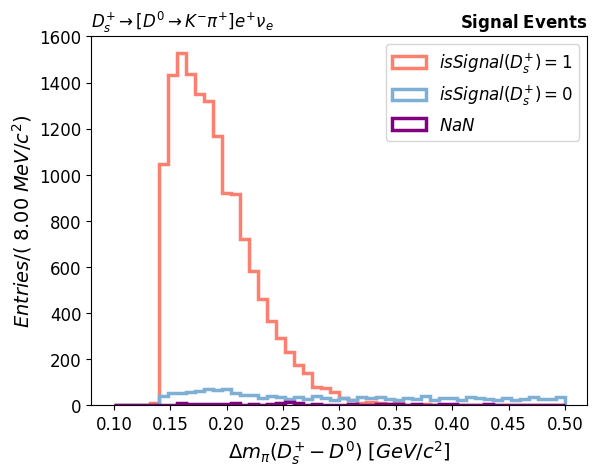


Signal km3pi, Ds_diff_D0pi, Width Per Bin: 8.00 MeV


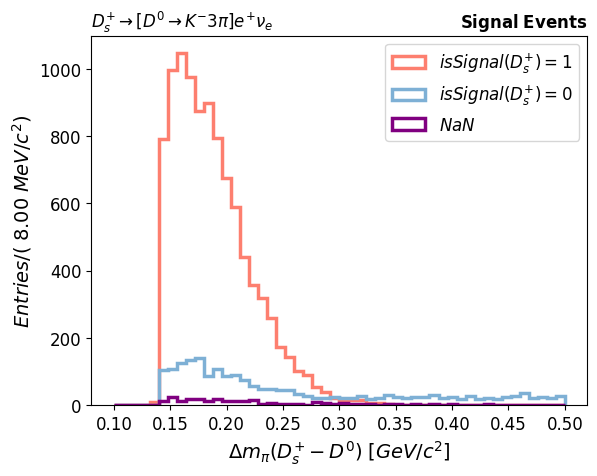


Signal kmpippi0_eff20_May2020, Ds_diff_D0pi, Width Per Bin: 8.00 MeV


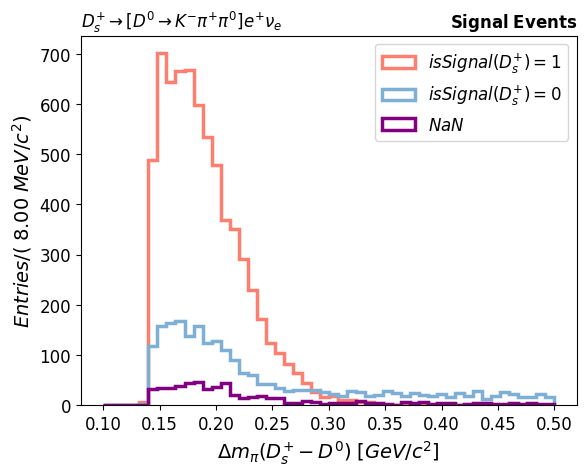

In [32]:
Bins = 50
Density = False
Stacked = False

# Plot Signal - Ds_diff_D0pi (Δm_pi)
Range = [0.1, 0.5]
var = "Ds_diff_D0pi"

for mode in decay_config.keys():
    perBin = ((Range[1] - Range[0]) / Bins) * 1000
    print(f"\nSignal {mode}, {var}, Width Per Bin: {perBin:.2f} MeV")

    df = DataFrames[f"Signal_{mode}"].copy()

    mask_sig = df["Ds_isSignal"] == 1
    mask_bkg = df["Ds_isSignal"] == 0
    mask_nan = df["Ds_isSignal"].isna()

    data = [
        df[mask_sig][var],   # true Ds signal
        df[mask_bkg][var],   # reconstructed Ds but not truth signal
        df[mask_nan][var],   # no truth match
    ]

    labels = [
        r"$isSignal(D_s^{+}) = 1$",
        r"$isSignal(D_s^{+}) = 0$",
        r"$NaN$",
    ]
    colors = ["#fd7f6f", "#7eb0d5", "purple"]

    plt.hist(
        data[::-1],
        color=colors[::-1],
        label=labels[::-1],
        alpha=1,
        range=Range,
        stacked=Stacked,
        density=Density,
        bins=Bins,
        histtype="step",
        linewidth=2.5,
    )

    # Left: full decay chain, Right: "Signal Events"
    title_left = mode_titles.get(mode, mode)
    plt.title(title_left, loc="left")
    plt.title(r"$\bf Signal\;Events$", loc="right")

    plt.ylabel(r"$Entries/(\; {width:.2f}\;MeV/c^2)$".format(width=perBin))
    plt.xlabel(r"$\Delta m_{\pi}(D_s^{+} - D^{0})\;[GeV/c^{2}]$")
    plt.legend()
    plt.show()


Signal kmpip, Ds_massDifference_0, Width Per Bin: 5.00 MeV


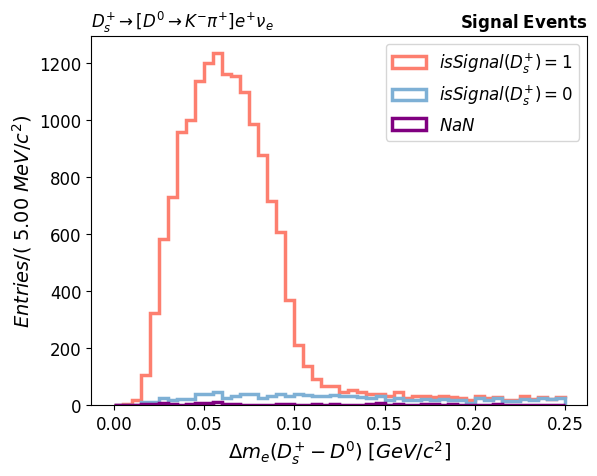


Signal km3pi, Ds_massDifference_0, Width Per Bin: 5.00 MeV


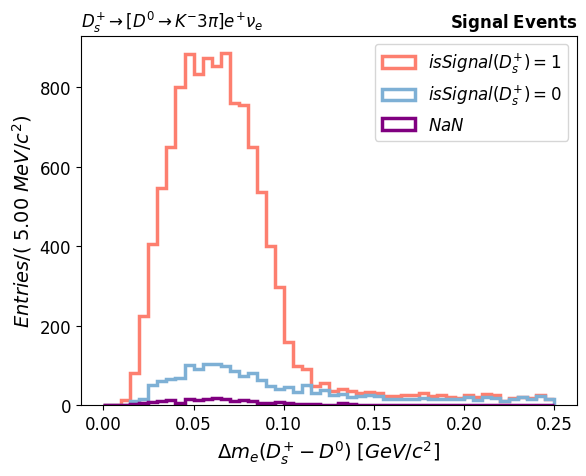


Signal kmpippi0_eff20_May2020, Ds_massDifference_0, Width Per Bin: 5.00 MeV


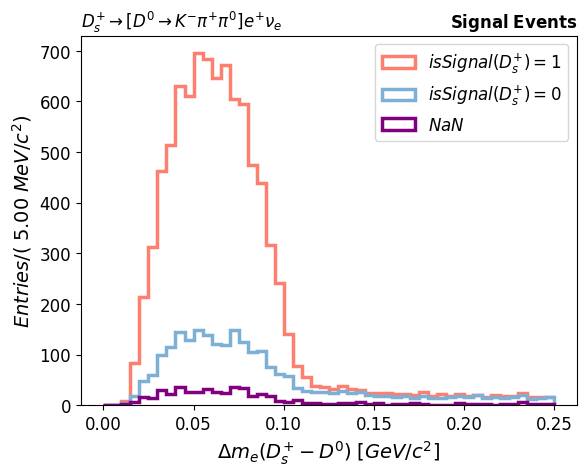

In [33]:
# Plot Signal - Ds_massDifference_0 (Δm_e)
Bins = 50
Density = False
Stacked = True
Range = [0.0, 0.25]
var = "Ds_massDifference_0"

for mode in decay_config.keys():
    perBin = ((Range[1] - Range[0]) / Bins) * 1000
    print(f"\nSignal {mode}, {var}, Width Per Bin: {perBin:.2f} MeV")

    df = DataFrames[f"Signal_{mode}"].copy()

    mask_sig = df["Ds_isSignal"] == 1
    mask_bkg = df["Ds_isSignal"] == 0
    mask_nan = df["Ds_isSignal"].isna()

    data = [
        df[mask_sig][var],
        df[mask_bkg][var],
        df[mask_nan][var],
    ]

    labels = [
        r"$isSignal(D_s^{+}) = 1$",
        r"$isSignal(D_s^{+}) = 0$",
        r"$NaN$",
    ]
    colors = ["#fd7f6f", "#7eb0d5", "purple"]

    plt.hist(
        data[::-1],
        color=colors[::-1],
        label=labels[::-1],
        alpha=1,
        range=Range,
        stacked=Stacked,
        density=Density,
        bins=Bins,
        histtype="step",
        linewidth=2.5,
    )

    # Left: full decay chain, Right: "Signal Events"
    title_left = mode_titles.get(mode, mode)
    plt.title(title_left, loc="left")
    plt.title(r"$\bf Signal\;Events$", loc="right")

    plt.ylabel(r"$Entries/(\; {width:.2f}\;MeV/c^2)$".format(width=perBin))
    plt.xlabel(r"$\Delta m_e(D_s^{+} - D^{0})\;[GeV/c^{2}]$")
    plt.legend()
    plt.show()

 ## Background composition by sample (per mode), no signal overlay, no gamma veto

 Uses `BACKGROUND_SAMPLES` and `BKG_GROUP_DEFS`. Groups are:
 * ccbar
 * charged
 * mixed
 * uds = uubar + ddbar + ssbar
 * taupair (only if you add it to BACKGROUND_SAMPLES)

 If later you merge charged and mixed into one group, just adjust BKG_GROUP_DEFS.

In [34]:
Stacked = True
Density = False
Bins = 50

def plot_bkg_composition(var, var_label, var_range):
    for mode in decay_config.keys():
        print(f"\n{'='*80}")
        print(f"Background composition for {var} in mode {mode}")
        print('='*80)

        # Build groups dynamically based on what is in BACKGROUND_SAMPLES
        group_vals = []
        group_labels = []

        for group in BKG_GROUP_DEFS:
            # restrict to members that are actually in BACKGROUND_SAMPLES
            member_samples = [
                s for s in group["samples"]
                if s in background_samples
            ]
            if not member_samples:
                continue

            # concatenate all members for this group for this mode
            dfs = [
                DataFrames[f"{s}_{mode}"]
                for s in member_samples
            ]
            df_group = pd.concat(dfs, ignore_index=True)

            vals = df_group[var].dropna()
            if len(vals) == 0:
                continue

            group_vals.append(vals)
            group_labels.append(group["label"])

        if not group_vals:
            print("  No background entries for this variable and mode, skipping.")
            continue

        # total counts and fractions
        counts_per_group = [len(v) for v in group_vals]
        n_bkg_tot = sum(counts_per_group)

        perBin = ((var_range[1] - var_range[0]) / Bins) * 1000
        print(f"  Width Per Bin: {perBin:.2f} MeV")
        print(f"  N_bkg total  = {n_bkg_tot}")

        for label, n in zip(group_labels, counts_per_group):
            frac = 100.0 * n / n_bkg_tot
            print(f"    {label} : {n} ({frac:.1f}%)")

        # Plot stacked hist
        plt.hist(
            group_vals[::-1],
            label=group_labels[::-1],
            density=Density,
            stacked=Stacked,
            bins=Bins,
            alpha=1,
            histtype="step",
            linewidth=2.5,
            range=var_range,
        )

        plt.title(
            r"$D_s^{+} \rightarrow [D^{0} \rightarrow K^{-} \pi^{+}] e^{+} \nu_{e}$"
            + f" ({mode})",
            loc="left",
        )
        plt.ylabel(r"$Entries/(\; {width:.2f}\;MeV/c^2)$".format(width=perBin))
        plt.xlabel(var_label)
        plt.legend()
        plt.show()


Background composition for Ds_massDifference_0 in mode kmpip
  Width Per Bin: 5.00 MeV
  N_bkg total  = 351780
    $c\bar{c}$ : 311413 (88.5%)
    $B^{+} B^{-}$ : 2167 (0.6%)
    $B^{0} \bar{B^{0}}$ : 928 (0.3%)
    $u\bar{u}, d\bar{d}, s\bar{s}$ : 37272 (10.6%)


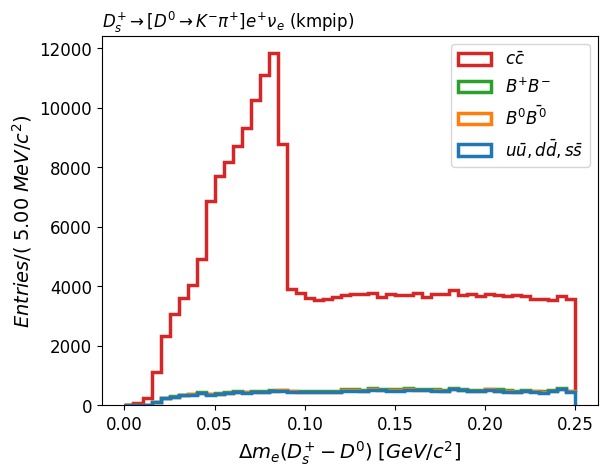


Background composition for Ds_massDifference_0 in mode km3pi
  Width Per Bin: 5.00 MeV
  N_bkg total  = 809611
    $c\bar{c}$ : 641201 (79.2%)
    $B^{+} B^{-}$ : 20919 (2.6%)
    $B^{0} \bar{B^{0}}$ : 17847 (2.2%)
    $u\bar{u}, d\bar{d}, s\bar{s}$ : 129644 (16.0%)


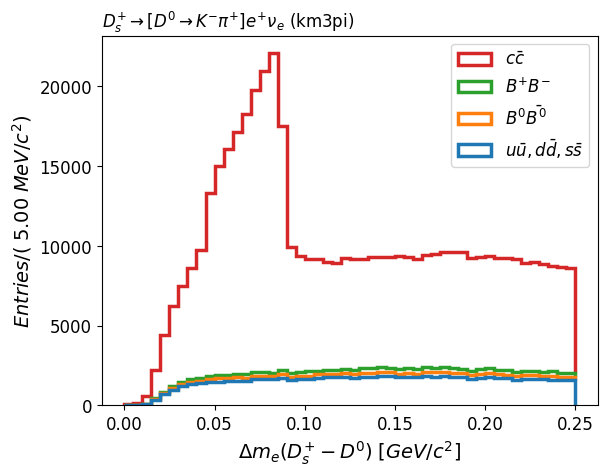


Background composition for Ds_massDifference_0 in mode kmpippi0_eff20_May2020
  Width Per Bin: 5.00 MeV
  N_bkg total  = 1264482
    $c\bar{c}$ : 884012 (69.9%)
    $B^{+} B^{-}$ : 35976 (2.8%)
    $B^{0} \bar{B^{0}}$ : 21497 (1.7%)
    $u\bar{u}, d\bar{d}, s\bar{s}$ : 322997 (25.5%)


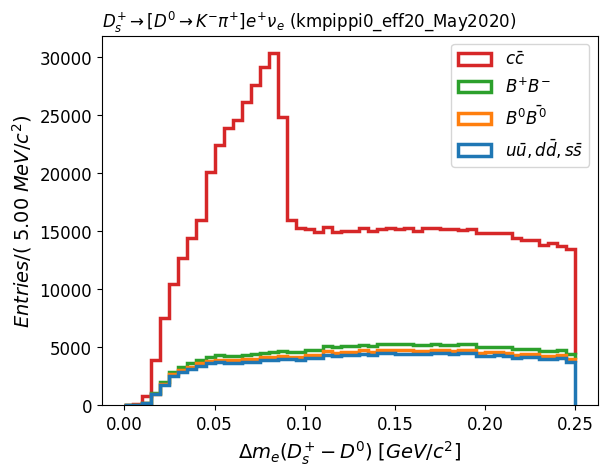


Background composition for Ds_diff_D0pi in mode kmpip
  Width Per Bin: 8.00 MeV
  N_bkg total  = 351780
    $c\bar{c}$ : 311413 (88.5%)
    $B^{+} B^{-}$ : 2167 (0.6%)
    $B^{0} \bar{B^{0}}$ : 928 (0.3%)
    $u\bar{u}, d\bar{d}, s\bar{s}$ : 37272 (10.6%)


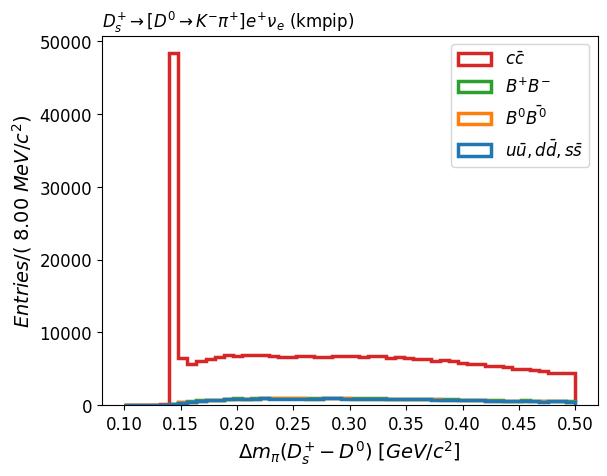


Background composition for Ds_diff_D0pi in mode km3pi
  Width Per Bin: 8.00 MeV
  N_bkg total  = 809611
    $c\bar{c}$ : 641201 (79.2%)
    $B^{+} B^{-}$ : 20919 (2.6%)
    $B^{0} \bar{B^{0}}$ : 17847 (2.2%)
    $u\bar{u}, d\bar{d}, s\bar{s}$ : 129644 (16.0%)


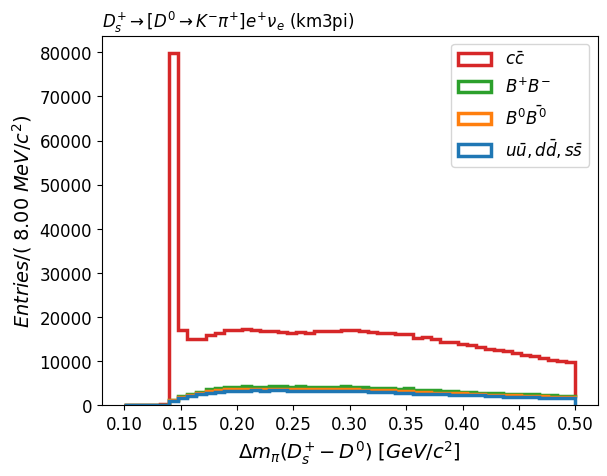


Background composition for Ds_diff_D0pi in mode kmpippi0_eff20_May2020
  Width Per Bin: 8.00 MeV
  N_bkg total  = 1264482
    $c\bar{c}$ : 884012 (69.9%)
    $B^{+} B^{-}$ : 35976 (2.8%)
    $B^{0} \bar{B^{0}}$ : 21497 (1.7%)
    $u\bar{u}, d\bar{d}, s\bar{s}$ : 322997 (25.5%)


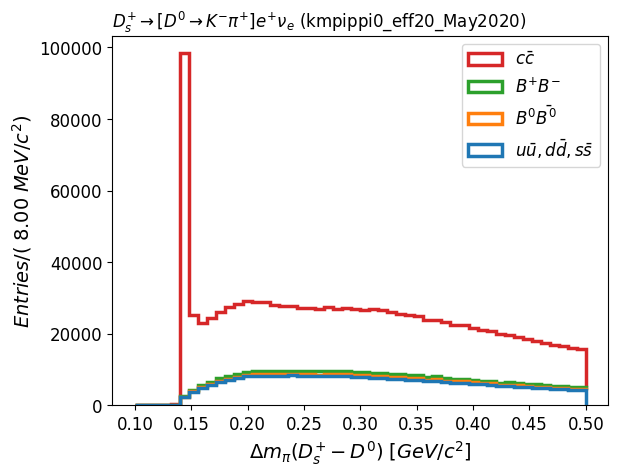

In [35]:
# Call for Ds_massDifference_0 (Δm_e) and Ds_diff_D0pi (Δm_pi)

plot_bkg_composition(
    var="Ds_massDifference_0",
    var_label=r"$\Delta m_e(D_s^{+} - D^{0})\;[GeV/c^{2}]$",
    var_range=[0.0, 0.25],
)

plot_bkg_composition(
    var="Ds_diff_D0pi",
    var_label=r"$\Delta m_{\pi}(D_s^{+} - D^{0})\;[GeV/c^{2}]$",
    var_range=[0.1, 0.5],
)

   ### Background plots (D* categories, no gamma veto)


Background kmpip, Ds_diff_D0pi, Width Per Bin: 8.00 MeV


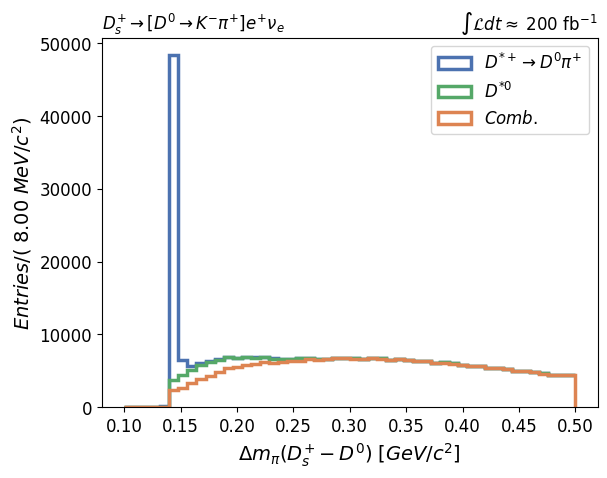


Background km3pi, Ds_diff_D0pi, Width Per Bin: 8.00 MeV


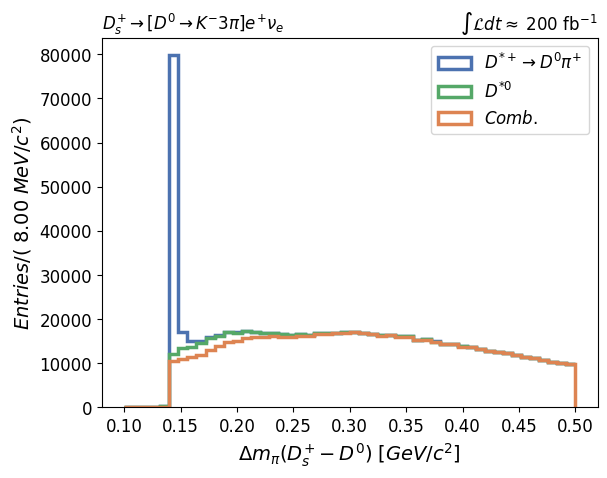


Background kmpippi0_eff20_May2020, Ds_diff_D0pi, Width Per Bin: 8.00 MeV


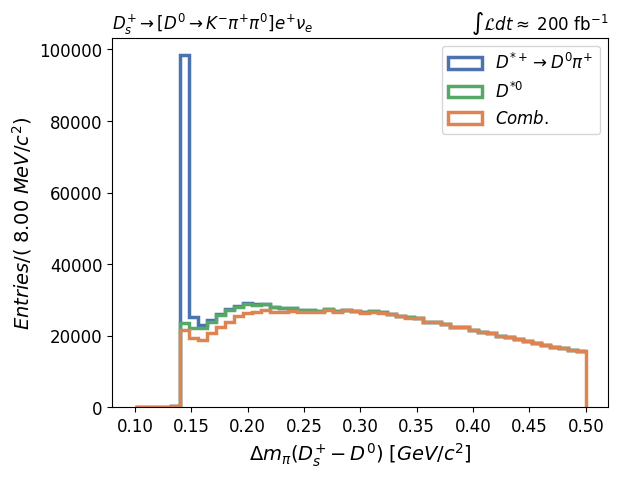

In [36]:
Bins = 50
Density = False
Stacked = True
Range = [0.1, 0.5]
var = "Ds_diff_D0pi"

for mode in decay_config.keys():
    perBin = ((Range[1] - Range[0]) / Bins) * 1000
    print(f"\nBackground {mode}, {var}, Width Per Bin: {perBin:.2f} MeV")

    df = DataFrames[f"All_{mode}"].copy()

    if USE_4_CATEGORIES:
        label1 = r"$Comb.$"
        label2 = r"$NaN$"
        label3 = r"$D^{*0}$"
        label4 = r"$D^{*+} \rightarrow D^{0} \pi^{+}$"

        labels = [label1, label2, label3, label4]
        colors = ["#DD8452", "#C44E52", "#55A868", "#4C72B0"]

        data = [
            df[(abs(df["Ds_mcPDG"]) != 413)
               & (abs(df["Ds_mcPDG"]) != 423)
               & (~df["Ds_mcPDG"].isna())][var],
            df[df["Ds_mcPDG"].isna()][var],
            df[abs(df["Ds_mcPDG"]) == 423][var],
            df[abs(df["Ds_mcPDG"]) == 413][var],
        ]
    else:  # 3 categories
        label1 = r"$Comb.$"
        label2 = r"$D^{*0}$"
        label3 = r"$D^{*+} \rightarrow D^{0} \pi^{+}$"

        labels = [label1, label2, label3]
        colors = ["#DD8452", "#55A868", "#4C72B0"]

        data = [
            df[(abs(df["Ds_mcPDG"]) != 413)
               & (abs(df["Ds_mcPDG"]) != 423)][var],
            df[abs(df["Ds_mcPDG"]) == 423][var],
            df[abs(df["Ds_mcPDG"]) == 413][var],
        ]

    plt.hist(
        data,
        color=colors,
        label=labels,
        density=Density,
        stacked=Stacked,
        bins=Bins,
        alpha=1,
        histtype="step",
        linewidth=2.5,
        range=Range,
    )

    # Left: full decay chain, Right: "Signal Events"
    title_left = mode_titles.get(mode, mode)
    plt.title(title_left, loc="left")
    plt.title(r"$\int\mathcal{L}dt\approx\;200$ fb$^{-1}$", loc="right")
    plt.ylabel(r"$Entries/(\; {width:.2f}\;MeV/c^2)$".format(width=perBin))
    plt.xlabel(r"$\Delta m_{\pi}(D_s^{+} - D^{0})\;[GeV/c^{2}]$")
    plt.legend(loc="upper right")
    # plt.ylim(0, 10000)
    plt.show()


Background kmpip, Ds_massDifference_0, Width Per Bin: 5.00 MeV


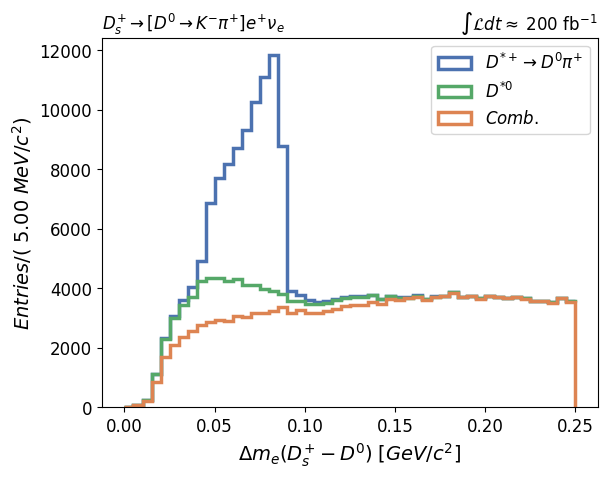


Background km3pi, Ds_massDifference_0, Width Per Bin: 5.00 MeV


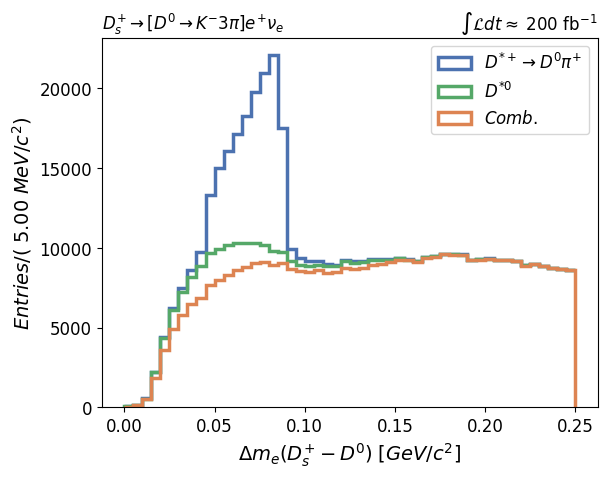


Background kmpippi0_eff20_May2020, Ds_massDifference_0, Width Per Bin: 5.00 MeV


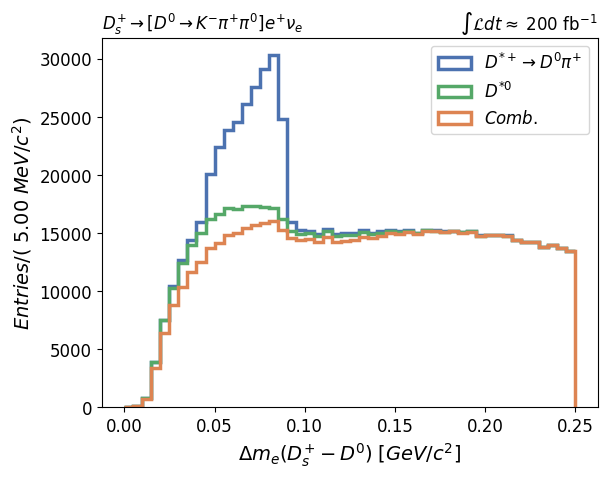

In [37]:
Bins = 50
Density = False
Stacked = True
Range = [0.0, 0.25]
var = "Ds_massDifference_0"

for mode in decay_config.keys():
    perBin = ((Range[1] - Range[0]) / Bins) * 1000
    print(f"\nBackground {mode}, {var}, Width Per Bin: {perBin:.2f} MeV")

    df = DataFrames[f"All_{mode}"].copy()

    if USE_4_CATEGORIES:
        label1 = r"$Comb.$"
        label2 = r"$NaN$"
        label3 = r"$D^{*0}$"
        label4 = r"$D^{*+} \rightarrow D^{0} \pi^{+}$"

        labels = [label1, label2, label3, label4]
        colors = ["#DD8452", "#C44E52", "#55A868", "#4C72B0"]

        data = [
            df[(abs(df["Ds_mcPDG"]) != 413)
               & (abs(df["Ds_mcPDG"]) != 423)
               & (~df["Ds_mcPDG"].isna())][var],
            df[df["Ds_mcPDG"].isna()][var],
            df[abs(df["Ds_mcPDG"]) == 423][var],
            df[abs(df["Ds_mcPDG"]) == 413][var],
        ]
    else:  # 3 categories
        label1 = r"$Comb.$"
        label2 = r"$D^{*0}$"
        label3 = r"$D^{*+} \rightarrow D^{0} \pi^{+}$"

        labels = [label1, label2, label3]
        colors = ["#DD8452", "#55A868", "#4C72B0"]

        data = [
            df[(abs(df["Ds_mcPDG"]) != 413)
               & (abs(df["Ds_mcPDG"]) != 423)][var],
            df[abs(df["Ds_mcPDG"]) == 423][var],
            df[abs(df["Ds_mcPDG"]) == 413][var],
        ]

    plt.hist(
        data,
        color=colors,
        label=labels,
        density=Density,
        stacked=Stacked,
        bins=Bins,
        alpha=1,
        histtype="step",
        linewidth=2.5,
        range=Range,
    )

    # Left: full decay chain, Right: "Signal Events"
    title_left = mode_titles.get(mode, mode)
    plt.title(title_left, loc="left")
    plt.title(r"$\int\mathcal{L}dt\approx\;200$ fb$^{-1}$", loc="right")
    plt.ylabel(r"$Entries/(\; {width:.2f}\;MeV/c^2)$".format(width=perBin))
    plt.xlabel(r"$\Delta m_e(D_s^{+} - D^{0})\;[GeV/c^{2}]$")
    plt.legend(loc="upper right")
    plt.show()

   # Deep analysis: Δm_e vs Δm_pi sanity checks (no veto)

   * Δm_e = Ds_massDifference_0 (electron mass on lepton track)
   * Δm_pi = Ds_diff_D0pi (pion mass on same track)
   * Signal: |Ds_mcPDG| = 431
   * Bkg1: |Ds_mcPDG| = 413 (D*+)
   * Bkg2: |Ds_mcPDG| = 423 (D*0)
   * Bkg3: everything else (combinatorial)


2D Structure (Δm_e, Δm_pi) - kmpip


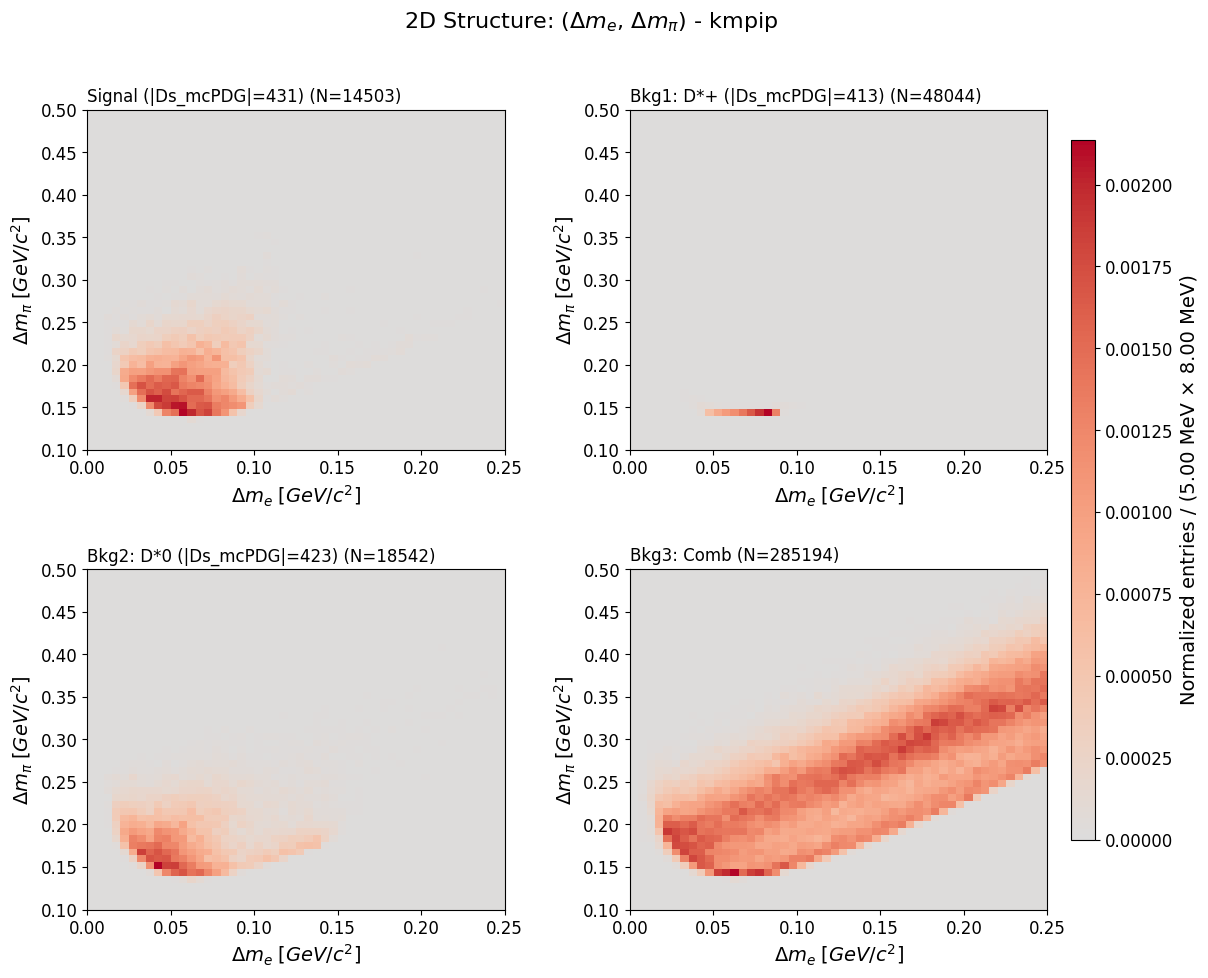


2D Structure (Δm_e, Δm_pi) - km3pi


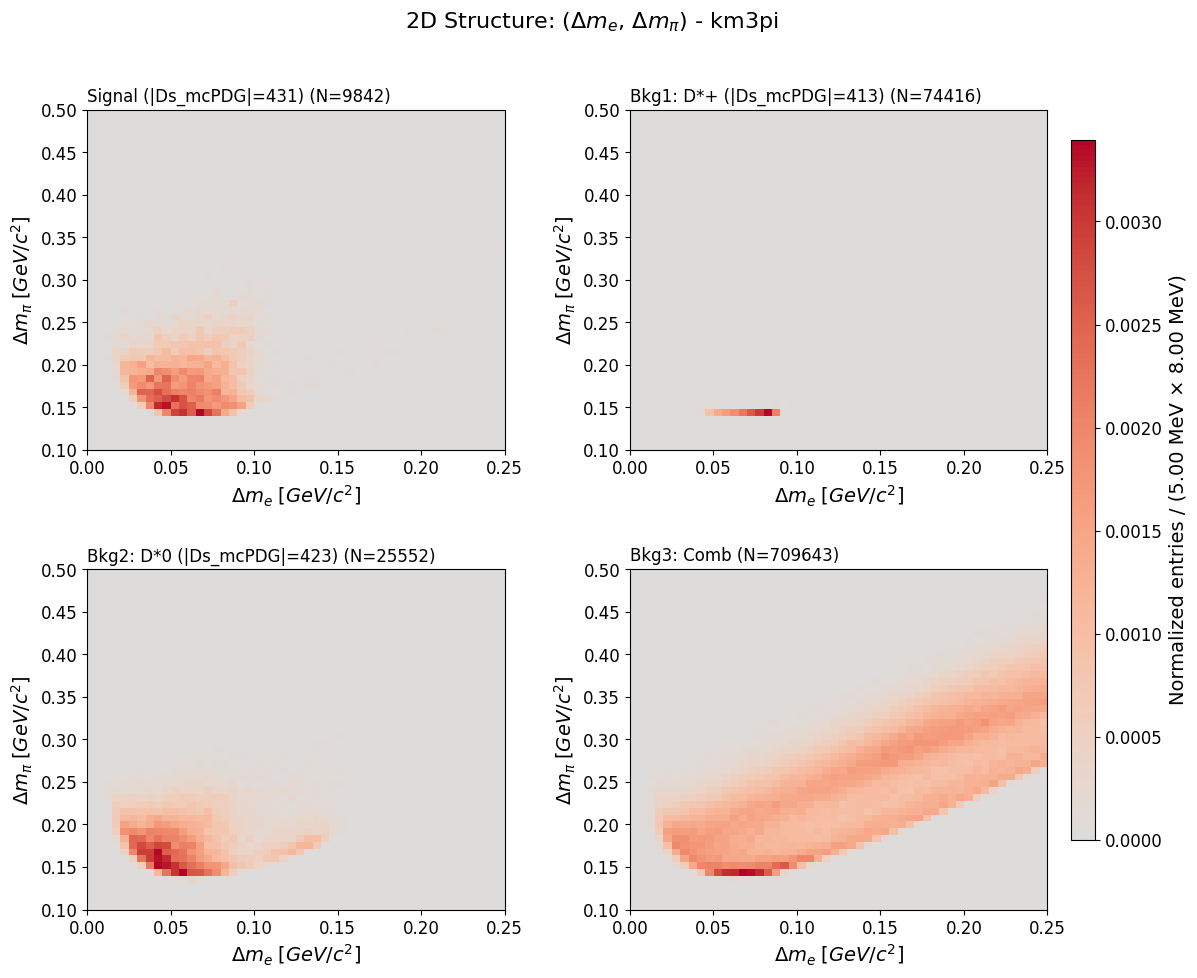


2D Structure (Δm_e, Δm_pi) - kmpippi0_eff20_May2020


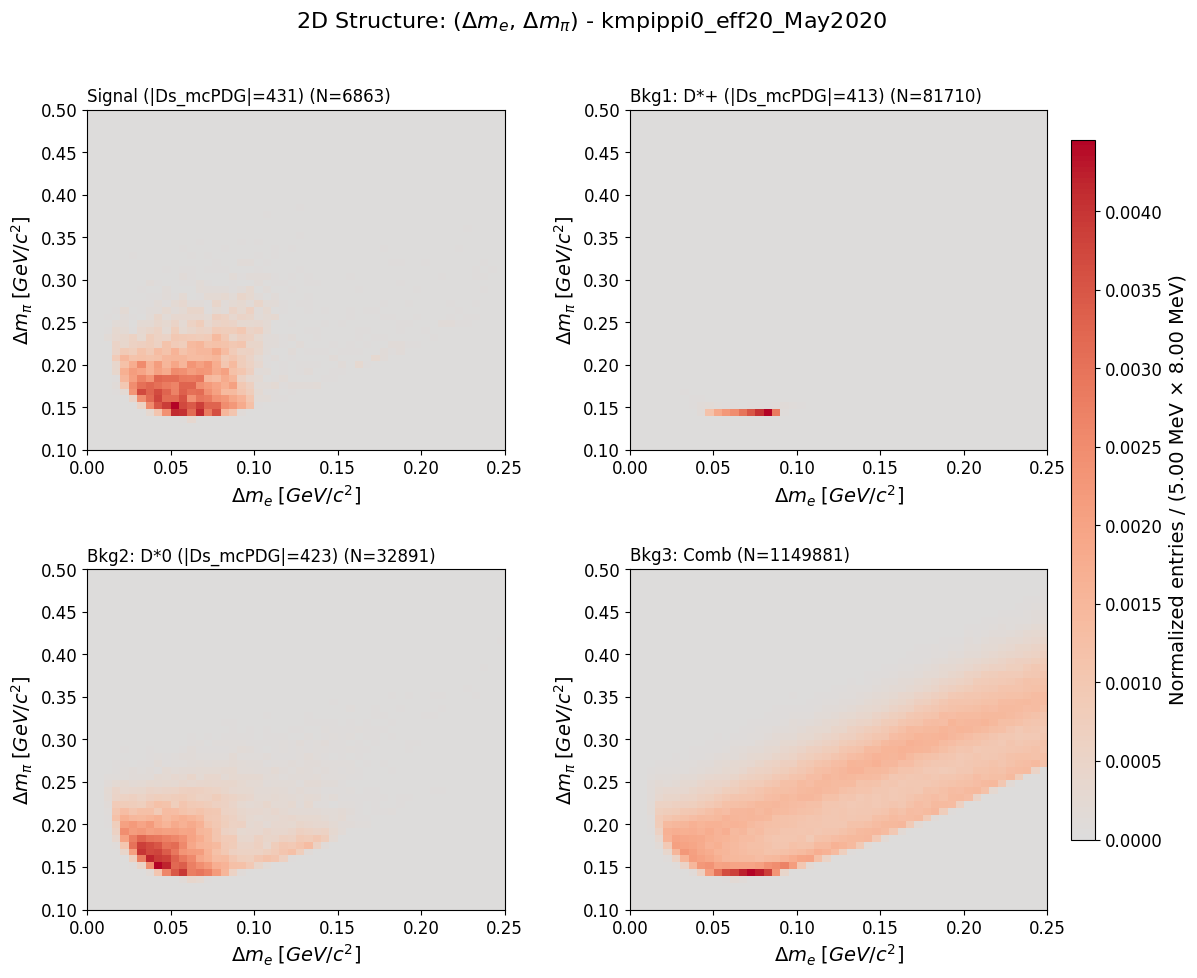

In [38]:
import matplotlib.colors as mcolors

bins_2d = [50, 50]
range_2d = [[0.0, 0.25], [0.10, 0.50]]  # [Δm_e, Δm_pi]

# bin widths in MeV for the colorbar label
bin_width_x = ((range_2d[0][1] - range_2d[0][0]) / bins_2d[0]) * 1000.0
bin_width_y = ((range_2d[1][1] - range_2d[1][0]) / bins_2d[1]) * 1000.0
cbar_label = r'Normalized entries / ({:.2f} MeV × {:.2f} MeV)'.format(
    bin_width_x, bin_width_y
)

# build a coolwarm-like cmap where 0 maps to white
base_cmap = plt.get_cmap("coolwarm")
cmap_vals = base_cmap(np.linspace(0.5, 1.0, 256))  # white to red side
cmap_2d = mcolors.LinearSegmentedColormap.from_list(
    "coolwarm_white_to_red", cmap_vals
)

for mode in decay_config.keys():
    print(f"\n{'='*80}")
    print(f"2D Structure (Δm_e, Δm_pi) - {mode}")
    print('='*80)

    df_sig = DataFrames[f"Signal_{mode}"].copy()
    df_bkg = DataFrames[f"All_{mode}"].copy()

    sig_mask = abs(df_sig["Ds_mcPDG"]) == 431
    df_sig = df_sig[sig_mask]

    bkg1 = df_bkg[abs(df_bkg["Ds_mcPDG"]) == 413].copy()
    bkg2 = df_bkg[abs(df_bkg["Ds_mcPDG"]) == 423].copy()
    bkg3 = df_bkg[
        (abs(df_bkg["Ds_mcPDG"]) != 413)
        & (abs(df_bkg["Ds_mcPDG"]) != 423)
    ].copy()

    datasets = {
        "Signal (|Ds_mcPDG|=431)": df_sig,
        "Bkg1: D*+ (|Ds_mcPDG|=413)": bkg1,
        "Bkg2: D*0 (|Ds_mcPDG|=423)": bkg2,
        "Bkg3: Comb": bkg3,
    }

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    im_last = None

    for idx, (name, df) in enumerate(datasets.items()):
        ax = axes[idx]

        if len(df) == 0:
            ax.set_title(f"{name} (N=0)", loc="left")
            ax.set_xlabel(r"$\Delta m_e\;[GeV/c^{2}]$")
            ax.set_ylabel(r"$\Delta m_\pi\;[GeV/c^{2}]$")
            continue

        H, xedges, yedges = np.histogram2d(
            df["Ds_massDifference_0"],  # Δm_e
            df["Ds_diff_D0pi"],         # Δm_pi
            bins=bins_2d,
            range=range_2d,
        )

        total = np.sum(H)
        if total > 0:
            H = H / total

        vmax = H.max() if H.max() > 0 else 1.0

        im_last = ax.imshow(
            H.T,
            origin="lower",
            aspect="auto",
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            cmap=cmap_2d,
            interpolation="nearest",
            vmin=0.0,
            vmax=vmax,
        )

        ax.set_xlabel(r"$\Delta m_e\;[GeV/c^{2}]$")
        ax.set_ylabel(r"$\Delta m_\pi\;[GeV/c^{2}]$")
        ax.set_title(f"{name} (N={len(df)})", loc="left")

    # layout so labels do not overlap
    fig.suptitle(
        f"2D Structure: ($\\Delta m_e$, $\\Delta m_\\pi$) - {mode}",
        fontsize=16,
    )
    fig.subplots_adjust(
        left=0.08, right=0.88, bottom=0.08, top=0.88,
        wspace=0.30, hspace=0.35
    )

    # single shared colorbar on the right
    if im_last is not None:
        cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.70])
        cbar = fig.colorbar(im_last, cax=cbar_ax)
        cbar.set_label(cbar_label)

    plt.show()


In [39]:
# # %% [markdown]
# # ## Helper: D0 daughter column mapping per mode

# # %%
# daughter_map = {
#     'kmpip': [
#         ('K_Ch1',  'K_Ch1_mcPDG',  'K_Ch1_genMotherPDG'),
#         ('pi_Ch1', 'pi_Ch1_mcPDG', 'pi_Ch1_genMotherPDG'),
#     ],
#     'kmpippi0_eff20_May2020': [
#         ('K_Ch2',   'K_Ch2_mcPDG',   'K_Ch2_genMotherPDG'),
#         ('pi_Ch2',  'pi_Ch2_mcPDG',  'pi_Ch2_genMotherPDG'),
#         ('pi0_Ch2', 'pi0_Ch2_mcPDG', 'pi0_Ch2_genMotherPDG'),
#     ],
#     'km3pi': [
#         ('K_Ch3',   'K_Ch3_mcPDG',   'K_Ch3_genMotherPDG'),
#         ('pi1_Ch3', 'pi1_Ch3_mcPDG', 'pi1_Ch3_genMotherPDG'),
#         ('pi2_Ch3', 'pi2_Ch3_mcPDG', 'pi2_Ch3_genMotherPDG'),
#         ('pi3_Ch3', 'pi3_Ch3_mcPDG', 'pi3_Ch3_genMotherPDG'),
#     ],
# }

# N_TOP = 5   # how many PDG categories to plot per variable
# Bins  = 50
# Range = [0.0, 0.25]
# var   = 'Ds_massDifference_0'

In [40]:
# # %% [markdown]
# # ## Electron mcPDG: top |e_mcPDG| categories in |Ds_mcPDG| == 23 (Signal)

# # %%
# for mode in decay_config.keys():
#     print(f"\n{'='*80}")
#     print(f'Electron mcPDG categories in |Ds_mcPDG| == 23, Signal_{mode}')
#     print('='*80)

#     df_sig = DataFrames[f"Signal_{mode}"].copy()
#     if 'e_mcPDG' not in df_sig.columns:
#         print("  No e_mcPDG column, skipping.")
#         continue

#     ds_abs = abs(df_sig['Ds_mcPDG'])
#     df_23  = df_sig[ds_abs == 23].copy()
#     print(f"  Total rows with |Ds_mcPDG| == 23: {len(df_23)}")
#     if len(df_23) == 0:
#         continue

#     # value counts
#     vc = abs(df_23['e_mcPDG']).value_counts(dropna=False)
#     print("\n  |e_mcPDG| value counts (normalized):")
#     print((vc / vc.sum()).head(15).apply(lambda x: f"{x:.6f}"))

#     # choose top N_TOP PDG codes (excluding NaN)
#     top_codes = [c for c in vc.index if not pd.isna(c)][:N_TOP]
#     print(f"\n  Top {len(top_codes)} |e_mcPDG| codes to plot:", top_codes)

#     # plot Δm_e shapes
#     plt.figure()
#     perBin = ((Range[1] - Range[0]) / Bins) * 1000
#     print(f"  Δm_e bin width: {perBin:.2f} MeV")

#     for code in top_codes:
#         subset = df_23[abs(df_23['e_mcPDG']) == code][var].dropna()
#         if len(subset) == 0:
#             continue
#         counts, edges = np.histogram(subset, bins=Bins, range=Range)
#         centers = 0.5 * (edges[:-1] + edges[1:])
#         plt.step(centers, counts, where='mid', linewidth=1.5,
#                  label=f'|e_mcPDG|={int(code)} (N={len(subset)})')

#     plt.xlabel(r'$\Delta m_e(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
#     plt.ylabel('Entries / bin')
#     plt.title(f'e_mcPDG categories, |Ds_mcPDG|=23, Signal_{mode}', loc='left')
#     plt.legend()
#     plt.show()

In [41]:
# # %% [markdown]
# # ## Electron genMotherPDG: top |e_genMotherPDG| in |Ds_mcPDG| == 23 (Signal)

# # %%
# for mode in decay_config.keys():
#     print(f"\n{'='*80}")
#     print(f'Electron genMotherPDG in |Ds_mcPDG| == 23, Signal_{mode}')
#     print('='*80)

#     df_sig = DataFrames[f"Signal_{mode}"].copy()
#     if 'e_genMotherPDG' not in df_sig.columns:
#         print("  No e_genMotherPDG column, skipping.")
#         continue

#     ds_abs = abs(df_sig['Ds_mcPDG'])
#     df_23  = df_sig[ds_abs == 23].copy()
#     print(f"  Total rows with |Ds_mcPDG| == 23: {len(df_23)}")
#     if len(df_23) == 0:
#         continue

#     vc = abs(df_23['e_genMotherPDG']).value_counts(dropna=False)
#     print("\n  |e_genMotherPDG| value counts (normalized):")
#     print((vc / vc.sum()).head(15).apply(lambda x: f"{x:.6f}"))

#     top_codes = [c for c in vc.index if not pd.isna(c)][:N_TOP]
#     print(f"\n  Top {len(top_codes)} |e_genMotherPDG| codes to plot:", top_codes)

#     plt.figure()
#     perBin = ((Range[1] - Range[0]) / Bins) * 1000
#     print(f"  Δm_e bin width: {perBin:.2f} MeV")

#     for code in top_codes:
#         subset = df_23[abs(df_23['e_genMotherPDG']) == code][var].dropna()
#         if len(subset) == 0:
#             continue
#         counts, edges = np.histogram(subset, bins=Bins, range=Range)
#         centers = 0.5 * (edges[:-1] + edges[1:])
#         plt.step(centers, counts, where='mid', linewidth=1.5,
#                  label=f'|e_genMotherPDG|={int(code)} (N={len(subset)})')

#     plt.xlabel(r'$\Delta m_e(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
#     plt.ylabel('Entries / bin')
#     plt.title(f'e_genMotherPDG categories, |Ds_mcPDG|=23, Signal_{mode}', loc='left')
#     plt.legend()
#     plt.show()

In [42]:
# # %% [markdown]
# # ## D0 daughters: mcPDG categories in |Ds_mcPDG| == 23 (Signal)

# # %%
# for mode in decay_config.keys():
#     print(f"\n{'='*80}")
#     print(f'D0 daughter mcPDG in |Ds_mcPDG| == 23, Signal_{mode}')
#     print('='*80)

#     if mode not in daughter_map:
#         print("  No daughter mapping defined for this mode.")
#         continue

#     df_sig = DataFrames[f"Signal_{mode}"].copy()
#     ds_abs = abs(df_sig['Ds_mcPDG'])
#     df_23  = df_sig[ds_abs == 23].copy()
#     print(f"  Total rows with |Ds_mcPDG| == 23: {len(df_23)}")
#     if len(df_23) == 0:
#         continue

#     for label, mc_col, mom_col in daughter_map[mode]:
#         print(f"\n  Daughter: {label}")
#         if mc_col not in df_23.columns:
#             print(f"    Column {mc_col} not found, skipping.")
#             continue

#         vc = abs(df_23[mc_col]).value_counts(dropna=False)
#         if vc.sum() == 0:
#             print("    No entries for this daughter.")
#             continue

#         print(f"    |{mc_col}| value counts (normalized):")
#         print((vc / vc.sum()).head(15).apply(lambda x: f"{x:.6f}"))

#         top_codes = [c for c in vc.index if not pd.isna(c)][:N_TOP]
#         print(f"    Top {len(top_codes)} |{mc_col}| codes to plot:", top_codes)

#         plt.figure()
#         perBin = ((Range[1] - Range[0]) / Bins) * 1000
#         print(f"    Δm_e bin width: {perBin:.2f} MeV")

#         for code in top_codes:
#             subset = df_23[abs(df_23[mc_col]) == code][var].dropna()
#             if len(subset) == 0:
#                 continue
#             counts, edges = np.histogram(subset, bins=Bins, range=Range)
#             centers = 0.5 * (edges[:-1] + edges[1:])
#             plt.step(centers, counts, where='mid', linewidth=1.5,
#                      label=f'|{mc_col}|={int(code)} (N={len(subset)})')

#         plt.xlabel(r'$\Delta m_e(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
#         plt.ylabel('Entries / bin')
#         plt.title(f'{label} mcPDG, |Ds_mcPDG|=23, Signal_{mode}', loc='left')
#         plt.legend()
#         plt.show()

In [43]:
# # %% [markdown]
# # ## D0 daughters: genMotherPDG categories in |Ds_mcPDG| == 23 (Signal)

# # %%
# for mode in decay_config.keys():
#     print(f"\n{'='*80}")
#     print(f'D0 daughter genMotherPDG in |Ds_mcPDG| == 23, Signal_{mode}')
#     print('='*80)

#     if mode not in daughter_map:
#         print("  No daughter mapping defined for this mode.")
#         continue

#     df_sig = DataFrames[f"Signal_{mode}"].copy()
#     ds_abs = abs(df_sig['Ds_mcPDG'])
#     df_23  = df_sig[ds_abs == 23].copy()
#     print(f"  Total rows with |Ds_mcPDG| == 23: {len(df_23)}")
#     if len(df_23) == 0:
#         continue

#     for label, mc_col, mom_col in daughter_map[mode]:
#         print(f"\n  Daughter: {label}")
#         if mom_col not in df_23.columns:
#             print(f"    Column {mom_col} not found, skipping.")
#             continue

#         vc = abs(df_23[mom_col]).value_counts(dropna=False)
#         if vc.sum() == 0:
#             print("    No entries for this daughter.")
#             continue

#         print(f"    |{mom_col}| value counts (normalized):")
#         print((vc / vc.sum()).head(15).apply(lambda x: f"{x:.6f}"))

#         top_codes = [c for c in vc.index if not pd.isna(c)][:N_TOP]
#         print(f"    Top {len(top_codes)} |{mom_col}| codes to plot:", top_codes)

#         plt.figure()
#         perBin = ((Range[1] - Range[0]) / Bins) * 1000
#         print(f"    Δm_e bin width: {perBin:.2f} MeV")

#         for code in top_codes:
#             subset = df_23[abs(df_23[mom_col]) == code][var].dropna()
#             if len(subset) == 0:
#                 continue
#             counts, edges = np.histogram(subset, bins=Bins, range=Range)
#             centers = 0.5 * (edges[:-1] + edges[1:])
#             plt.step(centers, counts, where='mid', linewidth=1.5,
#                      label=f'|{mom_col}|={int(code)} (N={len(subset)})')

#         plt.xlabel(r'$\Delta m_e(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
#         plt.ylabel('Entries / bin')
#         plt.title(f'{label} genMotherPDG, |Ds_mcPDG|=23, Signal_{mode}', loc='left')
#         plt.legend()
#         plt.show()

In [44]:
# # %% [markdown]
# # ## D0 daughters: mcMother_nMCDaughters, genMotherPDG_1, genMotherPDG_2
# # ## inside |Ds_mcPDG| == 23 (Signal only)

# # %%
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# # how many categories to plot per variable
# N_TOP = 5
# Bins = 50
# Range = [0.0, 0.25]
# var = 'Ds_massDifference_0'

# # mapping of daughters and the extra truth columns
# daughter_mother_map = {
#     'kmpip': [
#         ('K_Ch1',
#          'K_Ch1_mcMother_nMCDaughters',
#          'K_Ch1_genMotherPDG_1',
#          'K_Ch1_genMotherPDG_2'),
#         ('pi_Ch1',
#          'pi_Ch1_mcMother_nMCDaughters',
#          'pi_Ch1_genMotherPDG_1',
#          'pi_Ch1_genMotherPDG_2'),
#     ],
#     'kmpippi0_eff20_May2020': [
#         ('K_Ch2',
#          'K_Ch2_mcMother_nMCDaughters',
#          'K_Ch2_genMotherPDG_1',
#          'K_Ch2_genMotherPDG_2'),
#         ('pi_Ch2',
#          'pi_Ch2_mcMother_nMCDaughters',
#          'pi_Ch2_genMotherPDG_1',
#          'pi_Ch2_genMotherPDG_2'),
#         ('pi0_Ch2',
#          'pi0_Ch2_mcMother_nMCDaughters',
#          'pi0_Ch2_genMotherPDG_1',
#          'pi0_Ch2_genMotherPDG_2'),
#     ],
#     'km3pi': [
#         ('K_Ch3',
#          'K_Ch3_mcMother_nMCDaughters',
#          'K_Ch3_genMotherPDG_1',
#          'K_Ch3_genMotherPDG_2'),
#         ('pi1_Ch3',
#          'pi1_Ch3_mcMother_nMCDaughters',
#          'pi1_Ch3_genMotherPDG_1',
#          'pi1_Ch3_genMotherPDG_2'),
#         ('pi2_Ch3',
#          'pi2_Ch3_mcMother_nMCDaughters',
#          'pi2_Ch3_genMotherPDG_1',
#          'pi2_Ch3_genMotherPDG_2'),
#         ('pi3_Ch3',
#          'pi3_Ch3_mcMother_nMCDaughters',
#          'pi3_Ch3_genMotherPDG_1',
#          'pi3_Ch3_genMotherPDG_2'),
#     ],
# }


# def plot_dm_by_category(df_23, colname, mode, label_prefix):
#     """For a given column and mode, print value counts and plot Δm_e per top category."""
#     if colname not in df_23.columns:
#         print(f"    Column {colname} not found, skipping.")
#         return

#     # PDG-like vs nMCDaughters: treat counts without abs, PDG with abs
#     if colname.endswith('nMCDaughters'):
#         vc = df_23[colname].value_counts(dropna=False)
#         selector = lambda code: (df_23[colname] == code)
#         print_type = f"{colname} (nMCDaughters)"
#     else:
#         vc = abs(df_23[colname]).value_counts(dropna=False)
#         selector = lambda code: (abs(df_23[colname]) == code)
#         print_type = f"|{colname}|"

#     if vc.sum() == 0:
#         print(f"    No entries for {colname}.")
#         return

#     print(f"    {print_type} value counts (normalized):")
#     print((vc / vc.sum()).head(15).apply(lambda x: f"{x:.6f}"))

#     # pick top N_TOP non-NaN categories
#     top_codes = [c for c in vc.index if not pd.isna(c)][:N_TOP]
#     print(f"    Top {len(top_codes)} categories to plot:", top_codes)

#     # make Δm_e histograms per category
#     plt.figure()
#     perBin = ((Range[1] - Range[0]) / Bins) * 1000
#     print(f"    Δm_e bin width: {perBin:.2f} MeV")

#     for code in top_codes:
#         mask = selector(code)
#         subset = df_23[mask][var].dropna()
#         if len(subset) == 0:
#             continue

#         counts, edges = np.histogram(subset, bins=Bins, range=Range)
#         centers = 0.5 * (edges[:-1] + edges[1:])

#         # label with integer representation when possible
#         try:
#             code_label = int(code)
#         except Exception:
#             code_label = code

#         plt.step(
#             centers,
#             counts,
#             where='mid',
#             linewidth=1.5,
#             label=f'{print_type}={code_label} (N={len(subset)})'
#         )

#     plt.xlabel(r'$\Delta m_e(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
#     plt.ylabel('Entries / bin')
#     plt.title(f'{label_prefix}, |Ds_mcPDG|=23, Signal_{mode}', loc='left')
#     plt.legend()
#     plt.show()


# # main loop over modes and daughters
# for mode in decay_config.keys():
#     print(f"\n{'='*80}")
#     print(f'D0 daughter extended truth, |Ds_mcPDG| == 23, Signal_{mode}')
#     print('='*80)

#     if mode not in daughter_mother_map:
#         print("  No daughter mapping defined for this mode.")
#         continue

#     df_sig = DataFrames[f"Signal_{mode}"].copy()
#     ds_abs = abs(df_sig['Ds_mcPDG'])
#     df_23 = df_sig[ds_abs == 23].copy()
#     print(f"  Total rows with |Ds_mcPDG| == 23: {len(df_23)}")
#     if len(df_23) == 0:
#         continue

#     for (daughter_label,
#          col_nD,
#          col_mom1,
#          col_mom2) in daughter_mother_map[mode]:

#         print(f"\n  Daughter: {daughter_label}")

#         # mcMother_nMCDaughters
#         plot_dm_by_category(
#             df_23,
#             col_nD,
#             mode,
#             label_prefix=f'{daughter_label} mcMother_nMCDaughters'
#         )

#         # genMotherPDG_1
#         plot_dm_by_category(
#             df_23,
#             col_mom1,
#             mode,
#             label_prefix=f'{daughter_label} genMotherPDG_1'
#         )

#         # genMotherPDG_2
#         plot_dm_by_category(
#             df_23,
#             col_mom2,
#             mode,
#             label_prefix=f'{daughter_label} genMotherPDG_2'
#         )